In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import s2_selection_utility as ssu

Start import
Working on midway2-0417.rcc.local with the following versions 
and installation paths:
strax
	v0.13.4	/dali/lgrandi/strax/strax/strax
straxen
	v0.14.4	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [22]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_commissioning*',
                       available=('event_basics','peak_basics'))
dsets = dsets[(dsets.end > pd.to_datetime('01/26/2021'))] # earliest run
dsets = dsets[(dsets.end < pd.to_datetime('01/27/2021'))] # 
print('total number of runs:', len(dsets))

total number of runs: 22


In [23]:
dsets #25/01/2021: background

,name,number,mode,start,end,tags,livetime,raw_records_available,peak_basics_available,event_basics_available
102,012137,12137,tpc_commissioning_kr83m,2021-01-26 20:43:21.568,2021-01-26 21:13:24.525,,0 days 00:30:02.957000,False,True,True
104,012135,12135,tpc_commissioning_kr83m,2021-01-26 19:41:46.584,2021-01-26 20:11:49.265,,0 days 00:30:02.681000,False,True,True
107,012132,12132,tpc_commissioning_kr83m,2021-01-26 18:35:19.659,2021-01-26 18:50:22.030,,0 days 00:15:02.371000,False,True,True
109,012130,12130,tpc_commissioning_kr83m,2021-01-26 18:02:28.788,2021-01-26 18:17:30.264,,0 days 00:15:01.476000,False,True,True
111,012128,12128,tpc_commissioning_kr83m,2021-01-26 17:47:14.434,2021-01-26 18:02:14.510,,0 days 00:15:00.076000,False,True,True
112,012127,12127,tpc_commissioning_kr83m,2021-01-26 17:45:23.439,2021-01-26 17:46:26.685,,0 days 00:01:03.246000,False,True,True
113,012126,12126,tpc_commissioning,2021-01-26 17:32:57.851,2021-01-26 17:44:47.899,,0 days 00:11:50.048000,False,True,True
134,012105,12105,tpc_commissioning,2021-01-26 14:39:00.072,2021-01-26 14:59:12.324,,0 days 00:20:12.252000,False,True,True
135,012104,12104,tpc_commissioning,2021-01-26 13:38:42.976,2021-01-26 14:38:45.841,,0 days 01:00:02.865000,False,True,True
137,012102,12102,tpc_commissioning,2021-01-26 12:38:28.078,2021-01-26 13:38:28.750,,0 days 01:00:00.672000,False,True,True


In [19]:
dsets #26/01/2021: background + Kr-83m

,name,number,mode,start,end,tags,livetime,raw_records_available,peak_basics_available,event_basics_available
10,012229,12229,tpc_commissioning_kr83m,2021-01-28 06:36:15.942,2021-01-28 07:06:17.583,,0 days 00:30:01.641000,False,True,True
13,012226,12226,tpc_commissioning_kr83m,2021-01-28 05:05:21.605,2021-01-28 05:35:21.837,,0 days 00:30:00.232000,False,True,True
16,012223,12223,tpc_commissioning_kr83m,2021-01-28 03:34:34.970,2021-01-28 04:04:35.194,,0 days 00:30:00.224000,False,True,True
17,012222,12222,tpc_commissioning_kr83m,2021-01-28 03:04:20.655,2021-01-28 03:34:20.845,,0 days 00:30:00.190000,False,True,True
18,012221,12221,tpc_commissioning_kr83m,2021-01-28 02:34:06.188,2021-01-28 03:04:06.479,,0 days 00:30:00.291000,False,True,True
20,012219,12219,tpc_commissioning_kr83m,2021-01-28 01:33:34.155,2021-01-28 02:03:34.390,,0 days 00:30:00.235000,False,True,True
21,012218,12218,tpc_commissioning_kr83m,2021-01-28 01:03:16.741,2021-01-28 01:33:16.910,,0 days 00:30:00.169000,False,True,True
22,012217,12217,tpc_commissioning_kr83m,2021-01-28 00:33:02.022,2021-01-28 01:03:02.556,,0 days 00:30:00.534000,False,True,True
23,012216,12216,tpc_commissioning_kr83m,2021-01-28 00:02:44.263,2021-01-28 00:32:44.775,,0 days 00:30:00.512000,False,True,True
24,012215,12215,tpc_commissioning_kr83m,2021-01-27 23:32:29.048,2021-01-28 00:02:30.092,,0 days 00:30:01.044000,False,True,True


In [25]:
def plot_area_width_aft(run_id, low = 0, high = 6, low2 = 0, high2 = 1, binning = 500):
    events = st.get_array(run_id,'event_info')
    ph_s1 = Histdd(events['s1_area'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_area'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_area'], events['s1_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_area'], events['s2_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    #plt.yscale('log')

In [121]:
def plots2_area_width(run_id, low = 0, high = 6, low2 = 0, high2 = 6, binning = 500):
    events = st.get_array(run_id,'event_info')
    ph_s2 = Histdd(events['s2_area'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    
def plots2_area_aft(run_id, low = 0, high = 6, low3 = 0, high3 = 1, binning = 500):
    events = st.get_array(run_id,'event_info')
    phcs2 = Histdd(events['s2_area'], events['s2_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(low3, high3, binning)))
    plt.figure(figsize=(12,6))
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    #plt.yscale('log')

In [172]:
def drift_velocity(run_id, area_bounds, aft_bounds, width_bounds, low = 0, high = 6000, binning = 500,bplot=True):
    events = st.get_array(run_id,'event_info')
    events0 = events
    events = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_range_50p_area']>width_bounds[0]) & 
                      (events['s2_range_50p_area']<width_bounds[1]) &
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1])]
    
    plt.figure(figsize=(12,6))
    dt = np.linspace(low, high, binning)
    hdtime0 = Hist1d(events0['drift_time']/1e3, bins=dt)
    hdtime = Hist1d(events['drift_time']/1e3, bins=dt)
    if (bplot): hdtime.plot(color='b',label=f'background events')
    hdtime0.plot(color='black',label='all events')
    plt.ylabel("events", ha='right', y=1)
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
    plt.yscale('log')
    dropoff = dt[np.where(np.array(hdtime)>10)[0][-1]]
    plt.axvline(x=dropoff,linewidth=1,linestyle='--', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(12,6))
    area_ratio = np.divide(events['cs2'],events['cs1'])
    mh = Histdd(events['drift_time']/1e3, area_ratio,
            bins=(np.linspace(0, 6000, 200), np.logspace(0, 5, 200)))
    mh.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    plt.yscale('log')
    plt.axvline(x=dropoff,linewidth=1,linestyle='--', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
    
    plt.figure(figsize=(12,6))
    dts = np.linspace(0, 20, 200)
    mh_low = Histdd(events['drift_time']/1e3, area_ratio,
            bins=(dts, np.logspace(0, 5, 200)),axis_names=['drift_time', 'area_ratio'])
    mh_low.plot(log_scale=True, cblabel='events')
    median = mh_low.percentile(50, axis='area_ratio')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    median.plot(color='red',label='median')
    plt.yscale('log')
    gatedt = dts[np.where(np.array(median[:int(len(median)/2)])>70)[0][-1]]
    plt.axvline(x=gatedt,linewidth=1,linestyle='--', color='b',label=f'gate drift time = {gatedt:.1f} us')
    plt.legend(fontsize=14)
    vd = 150.2/(dropoff-gatedt)*1e4
    print(f'Drift velocity = {vd:.2f} m/s')
    return vd

In [177]:
def diffusion_model(t, D, vd, w0):
    sigma_to_r50p = stats.norm.ppf(0.75) - stats.norm.ppf(0.25)        
    return np.sqrt(2 * sigma_to_r50p**2 * D * t / vd**2 + w0**2)
def diffusion_constant(run_id, area_bounds, aft_bounds, width_bounds, fit_range, vd = 600):
    events = st.get_array(run_id,'event_info')

    data_cut = events[(events['s2_area']>area_bounds[0])&(events['s2_area']<area_bounds[1])&
                      (events['s2_range_50p_area']>width_bounds[0]) & 
                      (events['s2_range_50p_area']<width_bounds[1]) &
                      (events['s2_area_fraction_top']>aft_bounds[0]) & 
                      (events['s2_area_fraction_top']<aft_bounds[1])]
    # s2_width_50 vs drift_time
    t = np.linspace(0, 2000, 200)
    ph = Histdd(data_cut['drift_time']/1e3, data_cut['s2_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    
    #mean = np.array(ph.average(axis=1))
    #plt.plot(t[:len(mean)], mean, color='r',linestyle='-', label='mean per drift time slice')
    perc50 = np.array(ph.percentile(percentile=50, axis=1))
    plt.plot(t[:len(perc50)], perc50, color='b',linestyle='--', label='50% percentile')
    
    D_guess = 45e3 * units.cm**2 / units.s
    w0_guess = 500 * units.ns
    print(f'Drift velocity = {vd:.2f} m/s ')
    vd = vd * units.m / units.s
    guess = np.array([D_guess, vd, w0_guess])
    ys_m = diffusion_model(t, *guess)
    #plt.plot(t, ys_m, c='yellow',linestyle='--',label='initial guess')
    ll = np.where(t>fit_range[0])[0][0]
    hh = np.where(t>fit_range[1])[0][0]
    diffusion = lambda x, D, w0: diffusion_model(x, D, vd, w0)
    #popt, pcov = curve_fit(diffusion, t[ll:hh], mean[ll:hh], p0=(D_guess, w0_guess))
    popt, pcov = curve_fit(diffusion, t[ll:hh], perc50[ll:hh], p0=(D_guess, w0_guess))
    perr = np.sqrt(np.diag(pcov))
    plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
    ys_u = diffusion(t, *popt) + 1000
    ys_m = diffusion(t, *popt)
    ys_d = diffusion(t, *popt) - 1000

    plt.plot(t, ys_m, label=f'$D = {popt[0]/1e3/(units.cm**2 / units.s):.2f}$ cm$^2$/s',color='r')
    #plt.plot(t, ys_u,color='r')
    #plt.plot(t, ys_d,color='r')
    plt.legend(fontsize=14)
    #print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} +/- {perr[0]/1e3/(units.cm**2 / units.s):.2f} cm^2/s ')
    print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} cm^2/s ')
    print(f'w0 = {popt[1]/(units.ns):.2f} +/- {perr[1]/(units.ns):.2f} ns ')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

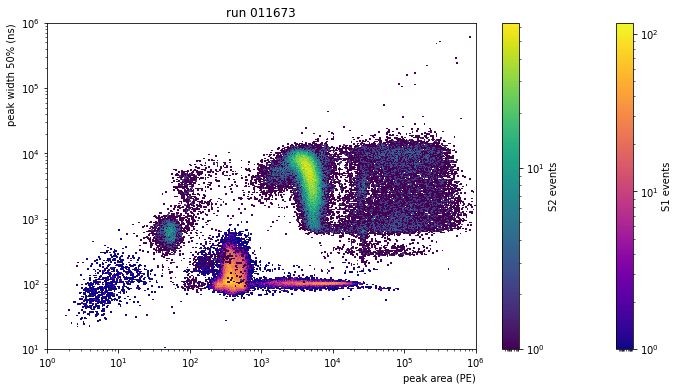

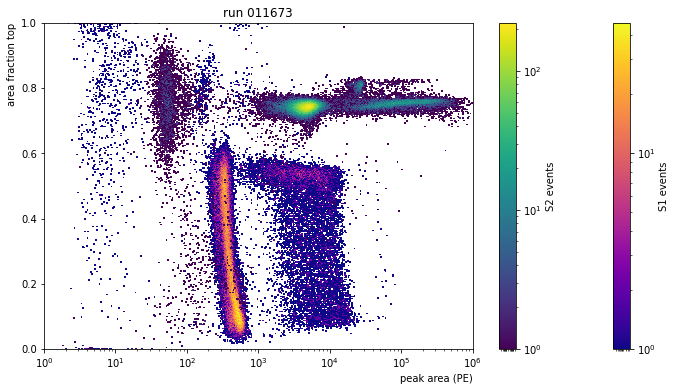

In [120]:
run_kr = '011673' #2021-01-05 15:25 00:15:01 DAQ test - Veto TRG: 6ms veto off, 10m veto on
plot_area_width_aft(run_kr)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

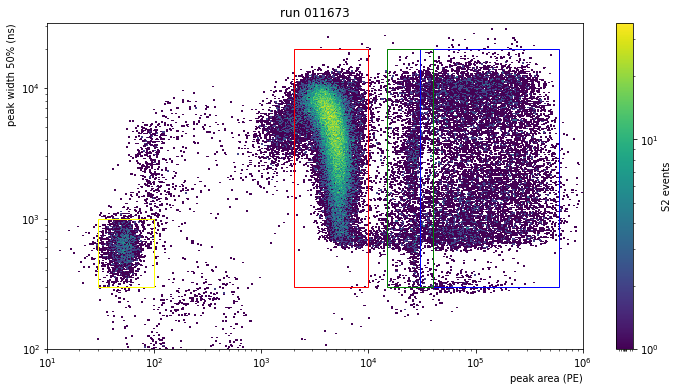

In [123]:
plots2_area_width(run_kr,1,6,2,4.5)
area0 = (30,100)
area1 = (2e3,1e4)
area2 = (3e4,6e5)
area3 = (1.5e4,4e4)
width0 = (300,1000)
width1 = (300,2e4)
width2 = (300,2e4)
width3 = (300,2e4)
psu.rectangle(area0, width0, 'yellow')
psu.rectangle(area1, width1, 'r')
psu.rectangle(area2, width2, 'b')
psu.rectangle(area3, width3, 'g')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

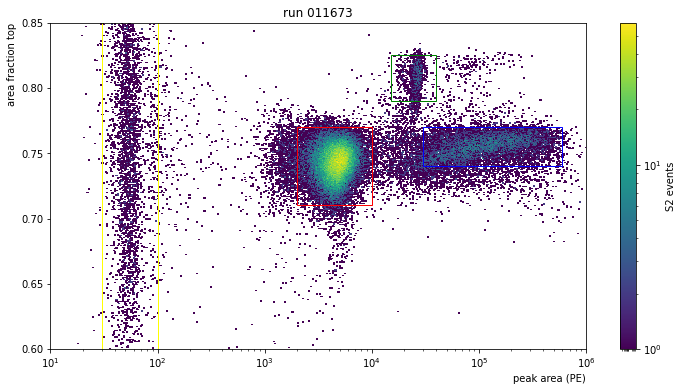

In [124]:
plots2_area_aft(run_kr,1,6,0.6,0.85)
aft1 = (0.71,0.77)
aft2 = (0.74,0.77)
aft3 = (0.79,0.825)
psu.rectangle(area0, (0,1), 'yellow')
psu.rectangle(area1, aft1, 'r')
psu.rectangle(area2, aft2, 'b')
psu.rectangle(area3, aft3, 'g')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

<ipython-input-172-1ebf6b08ce32>:24: RuntimeWarning: divide by zero encountered in true_divide
  area_ratio = np.divide(events['cs2'],events['cs1'])


Drift velocity = 607.20 m/s


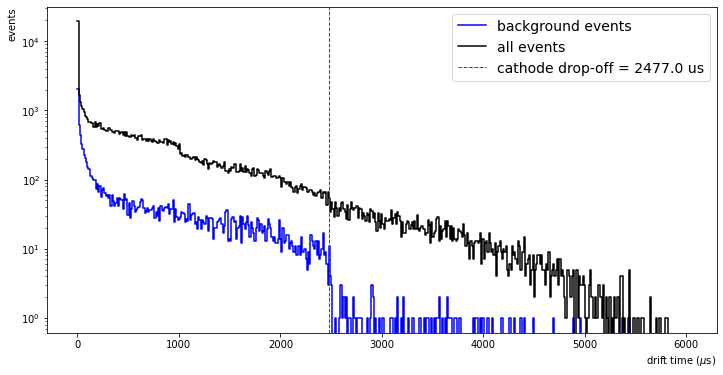

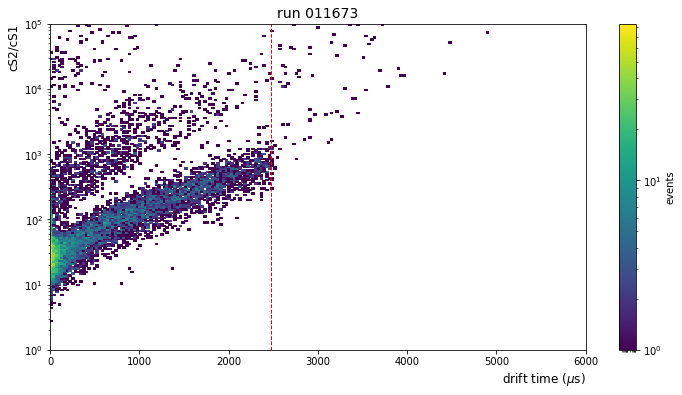

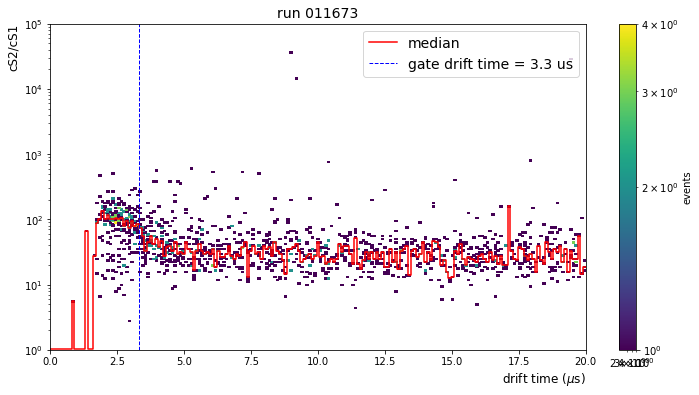

In [173]:
vd_kr = drift_velocity(run_kr,area2, aft2, width2)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 607.20 m/s 
Diffusion constant = 34.66 cm^2/s 
w0 = 404.61 +/- 150.02 ns 


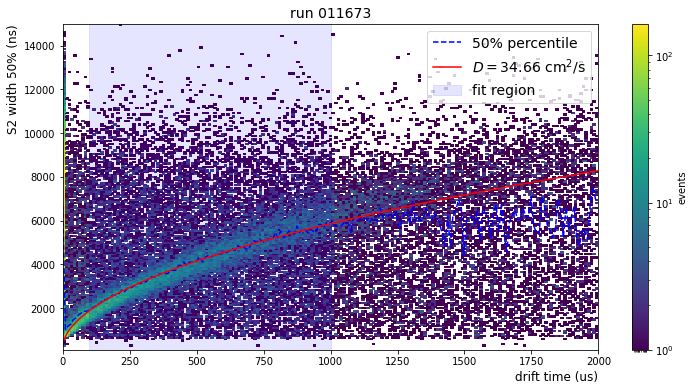

In [178]:
diffusion_constant(run_kr, area1, aft1, width1,fit_range=(100,1000),vd = vd_kr)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 607.20 m/s 
Diffusion constant = 44.17 cm^2/s 
w0 = -0.07 +/- inf ns 


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


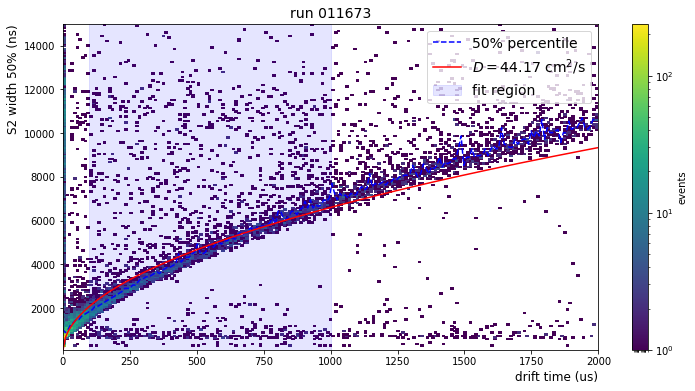

In [179]:
diffusion_constant(run_kr, area2, aft2, width2,fit_range=(100,1000),vd = vd_kr)

# Background Run

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

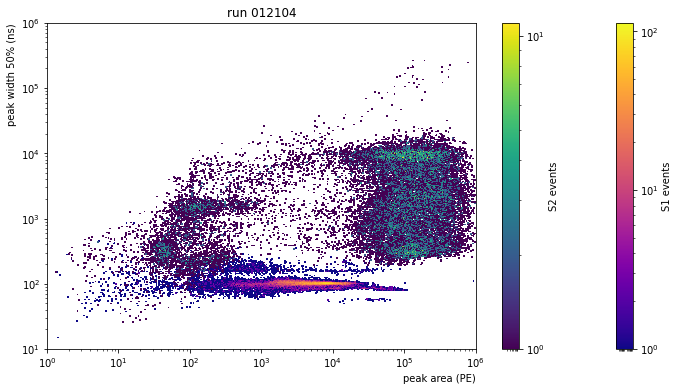

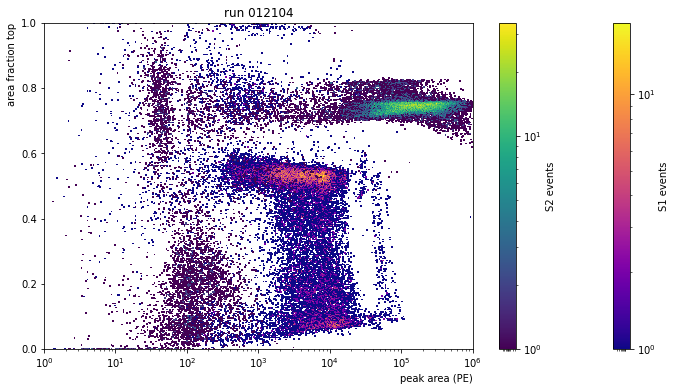

In [130]:
run_bkg = '012104'#	2021-01-26 14:38 01:00:02 BS and cathode at -2.75kV, gate at 0kV, SR at +400V, anode at +4.5kV, TS at -1.3kV, PMTs at a gain of 2e6 with a 1310V cutoff (PMT 260 at 1250V, PMTs 164, 352, 354, 362, 386, 393, 427 are off)
plot_area_width_aft(run_bkg)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

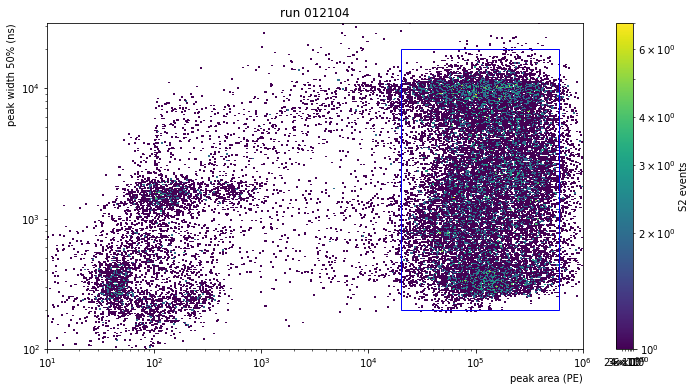

In [137]:
plots2_area_width(run_bkg,1,6,2,4.5)
area2 = (2e4,6e5)
width2 = (200,2e4)
psu.rectangle(area2, width2, 'b')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

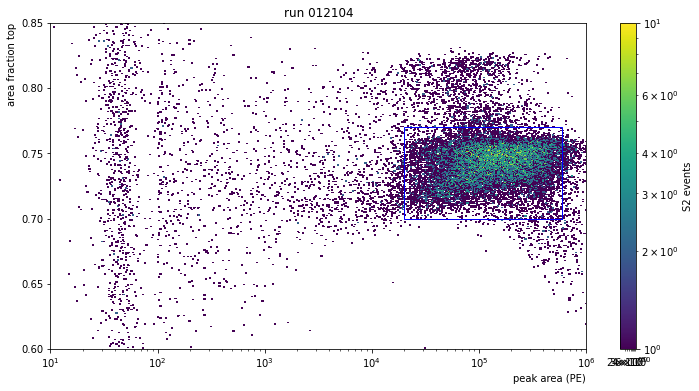

In [139]:
plots2_area_aft(run_bkg,1,6,0.6,0.85)
aft2 = (0.7,0.77)
psu.rectangle(area2, aft2, 'b')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

<ipython-input-172-1ebf6b08ce32>:24: RuntimeWarning: divide by zero encountered in true_divide
  area_ratio = np.divide(events['cs2'],events['cs1'])


Drift velocity = 740.62 m/s


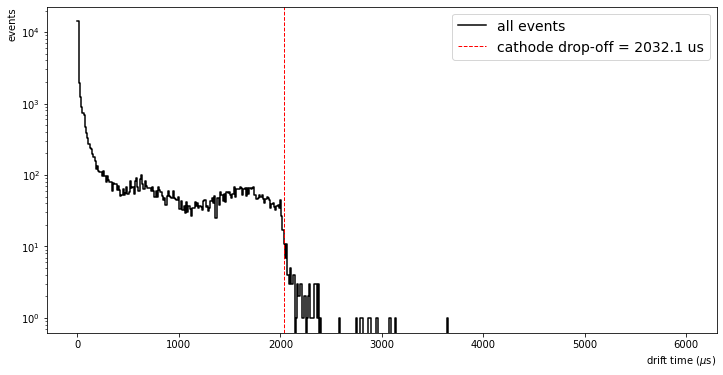

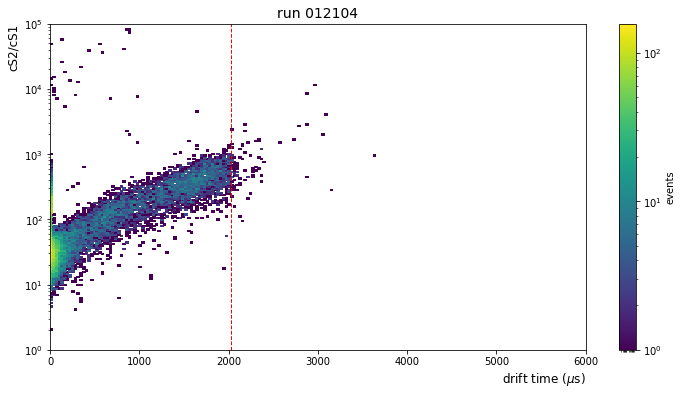

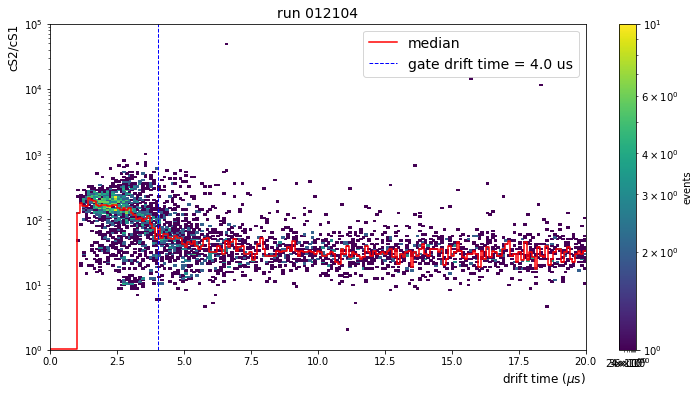

In [174]:
vd_bkg = drift_velocity(run_bkg,area2, aft2, width2,bplot=False)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 740.62 m/s 
Diffusion constant = 71.68 cm^2/s 
w0 = 1099.12 +/- 74.92 ns 


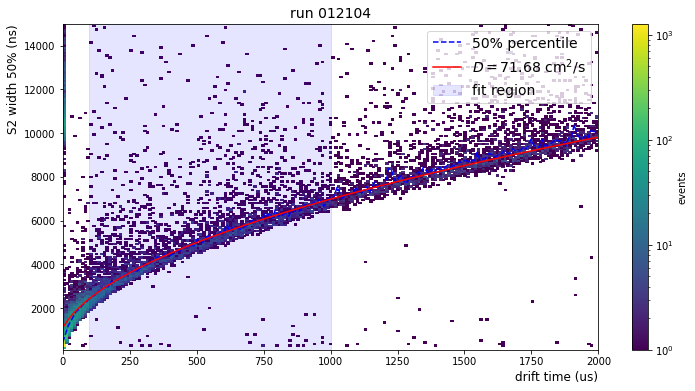

In [180]:
diffusion_constant(run_bkg, area2, aft2, width2,fit_range=(100,1000),vd = vd_bkg)

# New Kr-83m data

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

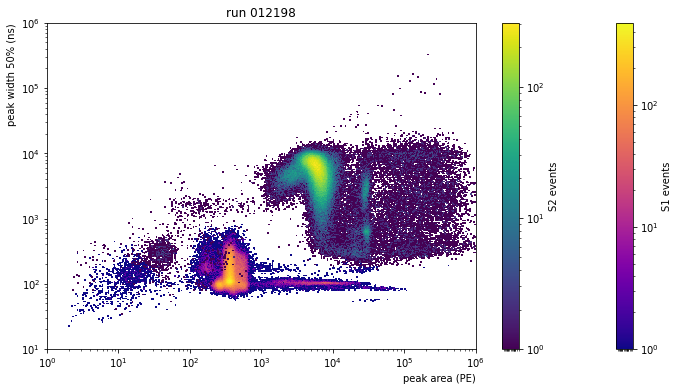

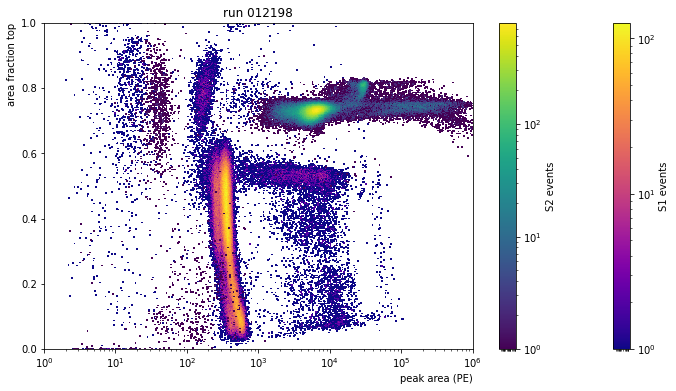

In [144]:
run_kr2 = '012198'
#2021-01-27 18:10 00:30:02 Needle valve mode (1 turns open). BS and cathode at -2.75kV, gate at 0kV, SR at +400V, anode at +4.5kV, TS at -1.3kV, Kr valve open, LXe, PMTs at a gain of 2e6 with a 1310V cutoff (PMT 260 at 1250V, PMTs 164, 352, 354, 362, 386, 393, 427 are off)
plot_area_width_aft(run_kr2)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

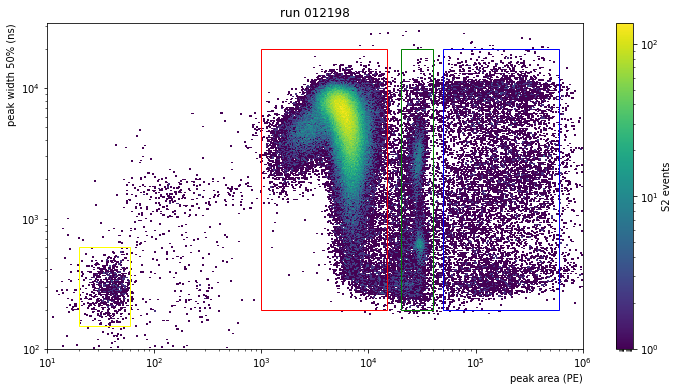

In [155]:
plots2_area_width(run_kr2,1,6,2,4.5)
area0 = (20,60)
area1 = (1e3,1.5e4)
area2 = (5e4,6e5)
area3 = (2e4,4e4)
width0 = (150,600)
width1 = (200,2e4)
width2 = (200,2e4)
width3 = (200,2e4)
psu.rectangle(area0, width0, 'yellow')
psu.rectangle(area1, width1, 'r')
psu.rectangle(area2, width2, 'b')
psu.rectangle(area3, width3, 'g')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

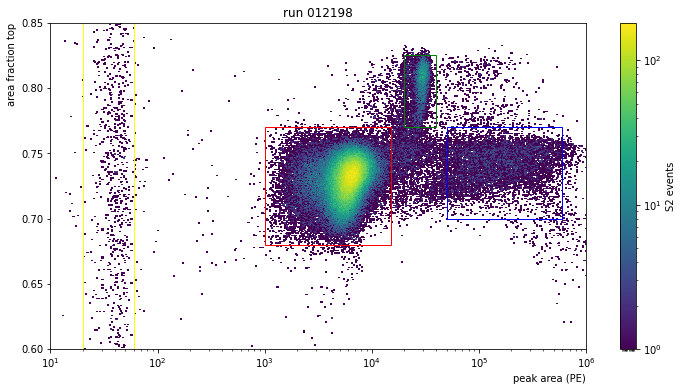

In [156]:
plots2_area_aft(run_kr2,1,6,0.6,0.85)
aft1 = (0.68,0.77)
aft2 = (0.7,0.77)
aft3 = (0.77,0.825)
psu.rectangle(area0, (0,1), 'yellow')
psu.rectangle(area1, aft1, 'r')
psu.rectangle(area2, aft2, 'b')
psu.rectangle(area3, aft3, 'g')

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

<ipython-input-172-1ebf6b08ce32>:24: RuntimeWarning: divide by zero encountered in true_divide
  area_ratio = np.divide(events['cs2'],events['cs1'])


Drift velocity = 745.22 m/s


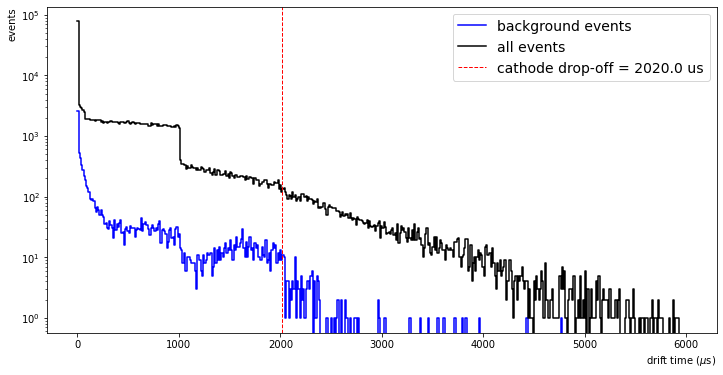

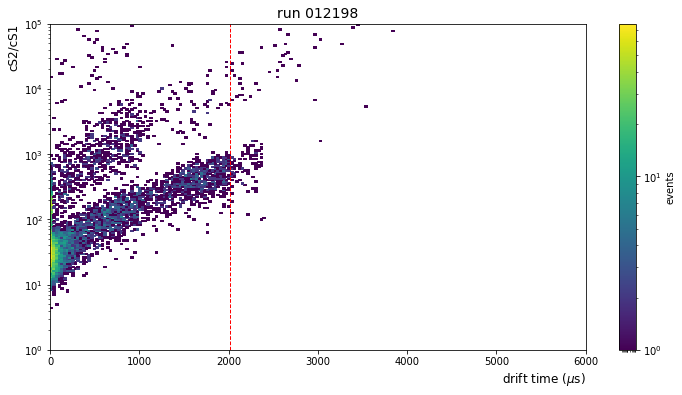

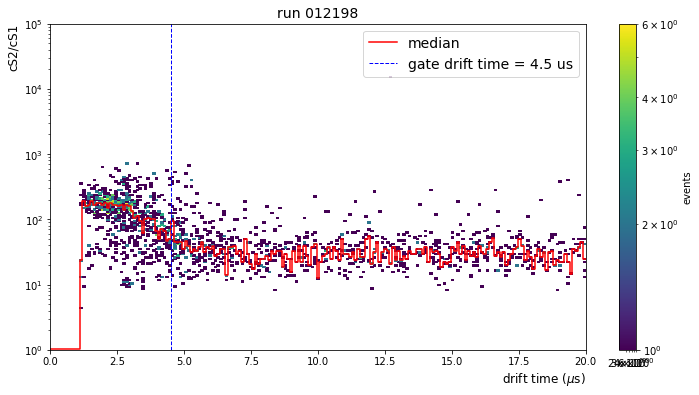

In [175]:
vd_kr2 = drift_velocity(run_kr2,area2, aft2, width2)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 745.22 m/s 
Diffusion constant = 59.66 cm^2/s 
w0 = 1333.65 +/- 27.03 ns 


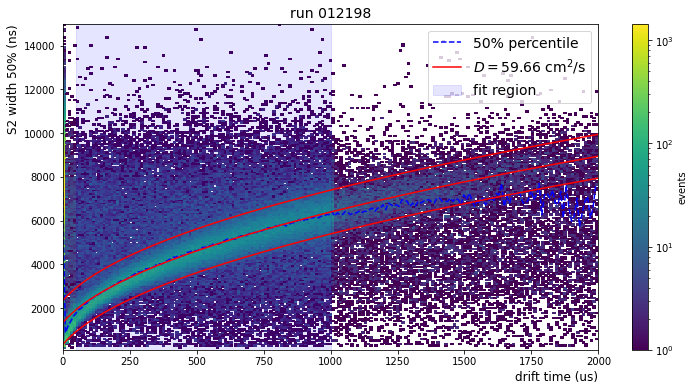

In [176]:
diffusion_constant(run_kr2, area1, aft1, width1,fit_range=(50,1000),vd = vd_kr2)

|          | 0.00 % [00:00<?], Rate last Chunk: nan s/chunk, #chunks processed: 0

Drift velocity = 744.23 m/s 
Diffusion constant = 73.96 cm^2/s 
w0 = 1068.59 +/- 141.72 ns 


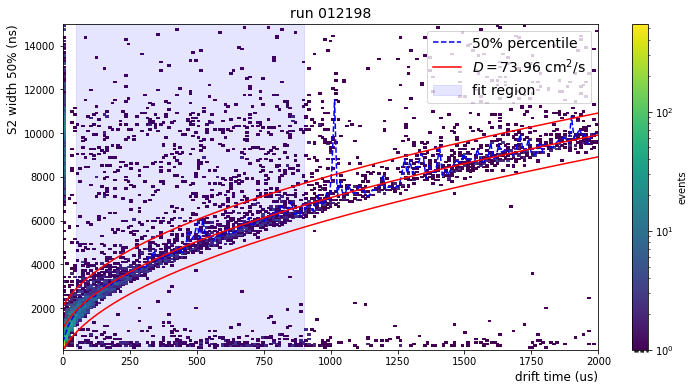

In [160]:
diffusion_constant(run_kr2, area2, aft2, width2,fit_range=(50,900),vd = vd_kr2)